# Set up a three boundary regional CESM-MOM6 run using CrocoDash

A typical workflow of utilizing CrocoDash consists of four main steps:

1. Generate a regional MOM6 domain.
2. Create the CESM case.
3. Prepare ocean forcing data.
4. Build and run the case.

# SECTION 1: Generate a regional MOM6 domain

We begin by defining a regional MOM6 domain using CrocoDash. To do so, we first carve out a subdomain from a 1/12 degree global grid. We then generate the topography by remapping an existing bathymetric dataset to our horizontal grid. Finally, we define a vertical grid.

## Step 1.1: Horizontal Grid

Extract a subgrid from a global grid using the `subgrid_from_supergrid` method:

In [6]:
%load_ext autoreload
%autoreload 2
from CrocoDash.case import Case

Edit2
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:

from CrocoDash.grid import Grid

grid = Grid.subgrid_from_supergrid(
    path = "/glade/work/fredc/cesm/grid/MOM6/tx1_12v1/gridgen/ocean_hgrid_trimmed.nc",  # supergrid
    llc = (5, -99),  # (l)ower (l)eft (c)orner coords
    urc = (59, -36.),  # (u)pper (r)ight (c)orner coords
    name = "nwa12"
)

## Step 1.2: Topography

In [13]:
from CrocoDash.topo import Topo

topo = Topo(
    grid = grid,
    min_depth = 9.5,
)

In [14]:
bathymetry_path='/glade/work/altuntas/croc/input/GEBCO_2024_coarse_x4.nc'

topo.interpolate_from_file(
    file_path = bathymetry_path,
    longitude_coordinate_name="lon",
    latitude_coordinate_name="lat",
    vertical_coordinate_name="elevation"
)

Begin regridding bathymetry...

Original bathymetry size: 104.42 Mb
Regridded size: 14.67 Mb
Automatic regridding may fail if your domain is too big! If this process hangs or crashes,open a terminal with appropriate computational and resources try calling ESMF directly in the input directory None via

`mpirun -np NUMBER_OF_CPUS ESMF_Regrid -s bathymetry_original.nc -d bathymetry_unfinished.nc -m bilinear --src_var depth --dst_var depth --netcdf4 --src_regional --dst_regional`

For details see https://xesmf.readthedocs.io/en/latest/large_problems_on_HPC.html

Afterwards, run the 'expt.tidy_bathymetry' method to skip the expensive interpolation step, and finishing metadata, encoding and cleanup.



Regridding successful! Now calling `tidy_bathymetry` method for some finishing touches...
Tidy bathymetry: Reading in regridded bathymetry to fix up metadata...done. Filling in inland lakes and channels... done.
setup bathymetry has finished successfully.


[autoreload of regional_mom6.regional_mom6 failed: Traceback (most recent call last):
  File "/glade/work/manishrv/conda-envs/CrocoDash/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/glade/work/manishrv/conda-envs/CrocoDash/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/glade/work/manishrv/conda-envs/CrocoDash/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 999, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/glade/u/home/manishrv/documents/nwa12_0.1/regional_mom_workflows/CrocoDash/CrocoDash/rm6/regional_mom6/regional_mom6.py", line 23, in <module>
    from . import regridding as r

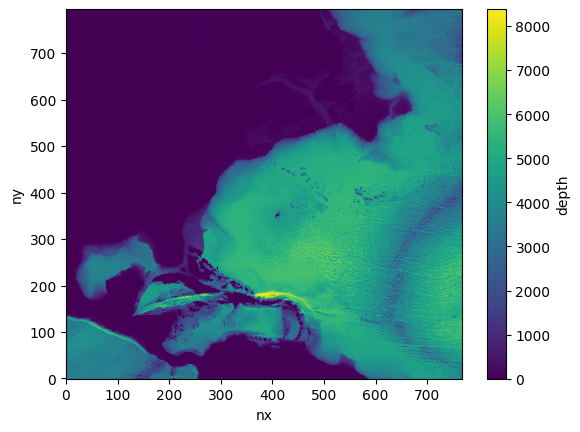

In [15]:
topo.depth.plot()

**TODO:** Implement a subset_global_topo-like method in mom6 and use it for this example instead of interpolation.

## Step 1.3: Vertical Grid

In [16]:
from CrocoDash.vgrid import VGrid

vgrid  = VGrid.hyperbolic(
    nk = 75,
    depth = topo.max_depth,
    ratio=20.0
)

# SECTION 2: Create the CESM case

After generating the MOM6 domain, the next step is to create a CESM case using CrocoDash. This process is straightforward and involves instantiating the CrocoDash Case object. The Case object requires the following inputs:

 - CESM Source Directory: A local path to a compatible CESM source copy.
 - Case Name: A unique name for the CESM case.
 - Input Directory: The directory where all necessary input files will be written.
 - MOM6 Domain Objects: The horizontal grid, topography, and vertical grid created in the previous section.
 - Project ID: (Optional) A project ID, if required by the machine.

In [17]:
from pathlib import Path


In [18]:
# CESM case (experiment) name
casename = "croc-case-three-boundary-nwa"

# CESM source root (Update this path accordingly!!!)
cesmroot = Path.home() / "documents"/"installs"/"clean_cesm3_0_alpha03a"

# Place where all your input files go 
inputdir = Path.home()  / "croc_input" / casename
    
# CESM case directory
caseroot =  Path.home() /"cases"/ "croc_cases" / casename

## Step 2.2: Create the Case

To create the CESM case, instantiate the `Case` object as shown below. This will automatically set up the CESM case based on the provided inputs: The `cesmroot` argument specifies the path to your local CESM source directory.
The `caseroot` argument defines the directory where the case will be created. CrocoDash will handle all necessary namelist modifications and XML changes to align with the MOM6 domain objects generated earlier.

In [19]:
%load_ext autoreload
%autoreload 2
from CrocoDash.case import Case

case = Case(
    cesmroot = cesmroot,
    caseroot = caseroot,
    inputdir = inputdir,
    ocn_grid = grid,
    ocn_vgrid = vgrid,
    ocn_topo = topo,
    project = 'NCGD0011',
    override = True,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


INFO:  csp_solver:CspSolver initialized.


Creating case...

• Updating ccs_config/modelgrid_aliases_nuopc.xml file to include the new resolution "croc-case-three-boundary-nwa" consisting of the following component grids.
 atm grid: "TL319", lnd grid: "TL319", ocn grid: "nwa12".

• Updating ccs_config/component_grids_nuopc.xml file to include newly generated ocean grid "nwa12" with the following properties:
 nx: 769, ny: 795. ocean mesh: /glade/u/home/manishrv/croc_input/croc-case-three-boundary-nwa/ocnice/ESMF_mesh_nwa12_9cfe04.nc.

Running the create_newcase tool with the following command:

/glade/u/home/manishrv/documents/installs/clean_cesm3_0_alpha03a/cime/scripts/create_newcase --compset 1850_DATM%JRA_SLND_SICE_MOM6_SROF_SGLC_SWAV --res croc-case-three-boundary-nwa --case /glade/u/home/manishrv/cases/croc_cases/croc-case-three-boundary-nwa --machine derecho --run-unsupported --project NCGD0011 

The create_newcase command was successful.

Navigating to the case directory:

cd /glade/u/home/manishrv/cases/croc_cases/croc-

INFO:	stage:SUCCESS: All stages are complete.


Case created successfully at /glade/u/home/manishrv/cases/croc_cases/croc-case-three-boundary-nwa.

To further customize, build, and run the case, navigate to the case directory in your terminal. To create another case, restart the notebook.



# Section 3: Prepare ocean forcing data

We need to cut out our ocean forcing. The package expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is `"east_unprocessed"` for segments and `"ic_unprocessed"` for the initial condition.

In this notebook, we are forcing with the Copernicus Marine "Glorys" reanalysis dataset. There's a function in the `CrocoDash` package, called `configure_forcings`, that generates a bash script to download the correct boundary forcing files for your experiment. First, you will need to create an account with Copernicus, and then call `copernicusmarine login` to set up your login details on your machine. Then you can run the `get_glorys_data.sh` bash script.

## Step 3.1 Configure Initial Conditions and Forcings


In [20]:
case.configure_forcings(
    date_range = ["2020-01-01 00:00:00", "2020-02-01 00:00:00"],
    boundaries = ["south", "north","east"], 
    tidal_constituents = ['M2'],
    tidal_data_dir = "/glade/u/home/manishrv/manish_scratch_symlink/inputs_rm6/tidal_data",
    tidal_data_suffix = "tpxo9.v1.nc"
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
This means that some areas may only have one or two layers between the surface and sea floor. 
For increased stability, consider increasing the minimum depth, or adjusting the vertical coordinate to add more layers near the surface.


NotImplementedError: Only rectangular grids are supported at this time.

## Step 3.2 Run `get_glorys_data.sh`

In a terminal session, locate the `get_glorys_data.sh` script and execute it to download the initial conditions and boundary conditions. Follow the instructions printed by the `configure_forcings` method above.


**TODO:** user copernicusmarine python API within CrocoDash, instead of directing users to run it via CLI. Also, on a derecho login node, both CLI and API fails to run due to the computational demand. We also need to address that.

##  Step 3.3: Process forcing data

In this final step, we call the `process_forcings` method of CrocoDash to cut out and interpolate the initial condition as well as all boundaries. CrocoDash also updates MOM6 runtime parameters and CESM xml variables accordingly.

In [11]:
case.process_forcings()

INITIAL CONDITIONS
Regridding Velocities... Done.
Regridding Tracers... Done.
Regridding Free surface... Done.
Saving outputs... done setting up initial condition.
[########################################] | 100% Completed | 101.69 ms
Done.
[########################################] | 100% Completed | 101.26 ms
Done.
[########################################] | 100% Completed | 101.47 ms
Done.
[########################################] | 100% Completed | 101.50 ms
Done.
Adding parameter changes to user_nl_mom:

  ! Initial conditions
  INIT_LAYERS_FROM_Z_FILE = True
  TEMP_SALT_Z_INIT_FILE = init_tracers.nc
  Z_INIT_FILE_PTEMP_VAR = temp
  Z_INIT_ALE_REMAPPING = True
  TEMP_SALT_INIT_VERTICAL_REMAP_ONLY = True
  DEPRESS_INITIAL_SURFACE = True
  SURFACE_HEIGHT_IC_FILE = init_eta.nc
  SURFACE_HEIGHT_IC_VAR = eta_t
  VELOCITY_CONFIG = file
  VELOCITY_FILE = init_vel.nc

  ! Open boundary conditions
  OBC_NUMBER_OF_SEGMENTS = 4
  OBC_FREESLIP_VORTICITY = False
  OBC_FREESLIP_STRAIN = Fals

# Section 4: Build and run the case

After completing the previous steps, you are ready to build and run your CESM case. Begin by navigating to the case root directory specified during the case creation. Before proceeding, review the `user_nl_mom` file located in the case directory. This file contains MOM6 parameter settings that were automatically generated by CrocoDash. Carefully examine these parameters and make any necessary adjustments to fine-tune the model for your specific requirements. While CrocoDash aims to provide a solid starting point, further tuning and adjustments are typically necessary to improve the model for your use case.

Once you have reviewed and modified the parameters as needed, you can prepare, build, and execute the case using the following commands: 
```
./case.setup
./case.build
./case.submit
```